Data analysis for PLR-3000 data
===============================

After bluetoothing accross, open the excel spreadsheet and save it in CSV format. Then run the code below.

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('paper', font_scale=1.2)

#plr3000 = pd.read_csv(
#    r'C:/Users/engs2242/Desktop/PLR-3000/R_20210312_132224.csv')

plr3000 = pd.read_csv(
    r'/Users/jtm/Projects/PyPlr/examples/PFR/data/neuroptics/R_20210414_162809.csv')

Seperate raw data from summary information
------------------------------------------

In [55]:
info = []
raw_data = []
for idx, row in plr3000.iterrows():
    information = row[[col for col in plr3000.columns if not 'Unnamed' in col]]
    raw = row[[col for col in plr3000.columns if 'Unnamed' in col]]
    dl = information['Data Length']
    time = raw.iloc[0:dl].to_numpy()
    pupil = raw.iloc[dl:dl*2].to_numpy()
    valid = raw.iloc[dl*2:dl*3].to_numpy()
    df = pd.DataFrame({'onset': time,
                       'diameter': pupil,
                       'valid': valid}, dtype=float)
    df['Record ID'] = information['Record ID']
    df['Patient ID'] = information['Patient ID']
    raw_data.append(df)
    info.append(information.to_frame().T)

info = pd.concat(info).set_index(['Record ID'])
raw_data = pd.concat(raw_data).set_index(['Record ID', 'onset'])
# set invalid samples to nan
raw_data.loc[raw_data.valid==0, 'diameter'] = np.nan
raw_data['diameter_pc'] = ((raw_data['diameter']/info['PLR Diameter Init'])-1) *100
neuroptics = raw_data.reset_index().rename(columns={'Record ID':'rec','Patient ID':'Subject','diameter':'pupil'})
neuroptics.onset = neuroptics.onset-1
neuroptics['Method'] = 'NeurOptics'
neuroptics.loc[neuroptics.Subject==0, 'Subject'] += 1
neuroptics['Subject'] = 'sub00' + neuroptics['Subject'].astype('str')
neuroptics

,rec,onset,pupil,valid,Subject,diameter_pc,Method
0,179,-1.000,5.659,1.0,sub002,-2.431034,NeurOptics
1,179,-0.967,5.677,1.0,sub002,-2.12069,NeurOptics
2,179,-0.933,5.674,1.0,sub002,-2.172414,NeurOptics
3,179,-0.900,5.654,1.0,sub002,-2.517241,NeurOptics
4,179,-0.866,5.719,1.0,sub002,-1.396552,NeurOptics
...,...,...,...,...,...,...,...
10795,120,7.857,4.500,1.0,sub001,0.0,NeurOptics
10796,120,7.890,4.456,1.0,sub001,-0.977778,NeurOptics
10797,120,7.924,4.497,1.0,sub001,-0.066667,NeurOptics
10798,120,7.957,4.482,1.0,sub001,-0.4,NeurOptics


In [56]:
import os
import os.path as op
import pandas as pd
datapath = r'/Users/jtm/Projects/PyPlr/examples/PFR/data/pyplr'
subs = os.listdir(datapath)
cols = ['diameter','diameter_3d','timestamp','confidence']
trials=[]
for sub in subs:
    subpath = op.join(datapath, sub)
    for rec in os.listdir(subpath):
        recpath = op.join(subpath, rec)
        data = pd.read_csv(op.join(recpath, 'raw_data.csv'), index_col='timestamp', usecols=cols)
        data['onset'] =  range(len(data))
        data['onset'] =  data['onset'] * 1/120-1
        data['Subject'] = sub
        data['rec'] = rec
        trials.append(data.reset_index())
        
trials = pd.concat(trials).reset_index(drop=True).rename(columns={'index':'onset'})
trials = trials.sort_values(['Subject','rec'])
trials

,timestamp,diameter,confidence,diameter_3d,onset,Subject,rec
59400,1541.458415,45.774245,0.983601,5.515972,-1.000000,sub001,rec000
59401,1541.466367,43.318788,0.057888,5.533923,-0.991667,sub001,rec000
59402,1541.474436,39.485776,0.711115,5.549734,-0.983333,sub001,rec000
59403,1541.482452,42.277045,0.739466,5.564221,-0.975000,sub001,rec000
59404,1541.490535,44.399923,0.927758,5.577575,-0.966667,sub001,rec000
...,...,...,...,...,...,...,...
9715,-619413.772202,41.934352,1.000000,4.620638,7.958333,sub002,rec021
9716,-619413.763777,41.980227,1.000000,4.623078,7.966667,sub002,rec021
9717,-619413.756214,41.943199,1.000000,4.625743,7.975000,sub002,rec021
9718,-619413.748166,41.929429,1.000000,4.628636,7.983333,sub002,rec021


In [57]:
trials.rename(columns={'diameter_3d':'Pupil Labs'}, inplace=True)
trials = trials.melt(
    value_vars=['Pupil Labs'],
    id_vars=['Subject','rec','onset'],
    value_name='pupil',
    var_name='Method')
trials = trials[trials.Subject!='sub001_old']
trials

,Subject,rec,onset,Method,pupil
0,sub001,rec000,-1.000000,Pupil Labs,5.515972
1,sub001,rec000,-0.991667,Pupil Labs,5.533923
2,sub001,rec000,-0.983333,Pupil Labs,5.549734
3,sub001,rec000,-0.975000,Pupil Labs,5.564221
4,sub001,rec000,-0.966667,Pupil Labs,5.577575
...,...,...,...,...,...
70195,sub002,rec021,7.958333,Pupil Labs,4.620638
70196,sub002,rec021,7.966667,Pupil Labs,4.623078
70197,sub002,rec021,7.975000,Pupil Labs,4.625743
70198,sub002,rec021,7.983333,Pupil Labs,4.628636


In [58]:
data = neuroptics.append(trials[['rec', 'onset', 'pupil', 'Subject', 'Method']])
#data = data[data.Method!='Pupil Labs (px)']

In [59]:
data = data.sort_values('Subject')

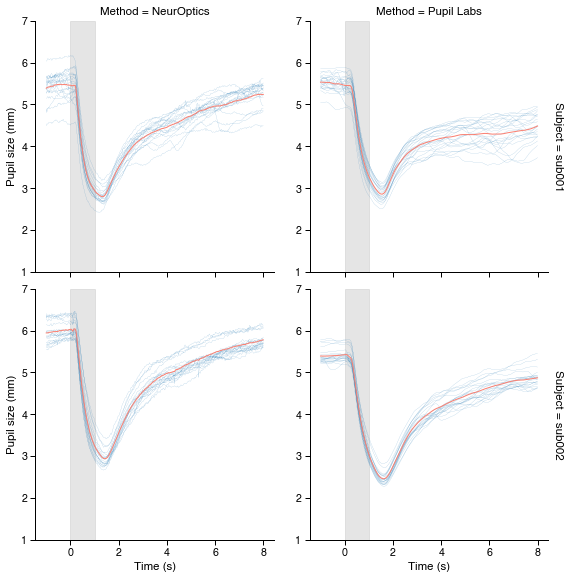

In [61]:
order = ['NeurOptics', 'Pupil Labs']
g = sns.FacetGrid(data=data, row='Subject', col='Method', sharey=False, margin_titles=True, height=4, col_order=order)
g.map_dataframe(sns.lineplot, x='onset', y='pupil', estimator=None, units='rec', lw=.1)
g.map_dataframe(sns.lineplot, x='onset', y='pupil', ci=None, lw=1, color='salmon')

axs = [ax for sublist in g.axes for ax in sublist]
for i, ax in enumerate(axs):
    ax.axvspan(0,1,color='k', alpha=.1)
    ax.set_xlabel('Time (s)')
    ax.set_ylim((1,7))
    if i%2 == 0:
        ax.set_ylabel('Pupil size (mm)')

g.savefig('../img/PLR-3000-Pupil-Core-PLRs.tiff', dpi=300)

In [62]:
cols = ['PLR Diameter Init', 'PLR Diameter End', 'PLR Latency',
       'PLR Constriction Velocity', 'PLR Max Constriction Velocity',
       'PLR Dilation Velocity', 'PLR T75']
info[cols] = info[cols].astype('float')
info.groupby('Patient ID')[cols].agg('mean')


,PLR Diameter Init,PLR Diameter End,PLR Latency,PLR Constriction Velocity,PLR Max Constriction Velocity,PLR Dilation Velocity,PLR T75
Patient ID,,,,,,,
0,5.44,2.785,0.2165,-3.5425,-6.121,1.0380,3.809444
2,6.02,2.935,0.2285,-3.4690,-5.769,1.1395,3.556500


In [63]:
info.groupby('Patient ID')[cols].agg('std')

,PLR Diameter Init,PLR Diameter End,PLR Latency,PLR Constriction Velocity,PLR Max Constriction Velocity,PLR Dilation Velocity,PLR T75
Patient ID,,,,,,,
0,0.357477,0.178517,0.015313,0.305405,0.478230,0.199832,1.217154
2,0.206729,0.184320,0.006708,0.222590,0.393231,0.170309,0.548800


In [64]:
from pyplr.plr import PLR

params = []
plrs = []

for idxs, df in trials.groupby(['Subject', 'rec']):
    data = df.loc[df.Method=='Pupil Labs', 'pupil'].to_numpy()
    plrs.append(data)
    plr = PLR(data, sample_rate=120, onset_idx=120, stim_duration=1)
    parameters = plr.parameters().T
    parameters[['Subject', 'Rec']] = idxs
    params.append(parameters)
params = pd.concat(params).set_index(['Subject', 'Rec'])
params

Baseline  Latency_a  Latency_b  T2MaxVel  T2MaxCon  T2Rec75pc  \
Subject Rec                                                                     
sub001  rec000  5.573743   0.341667   0.291667  0.500000  1.541667   0.000000   
        rec001  5.552783   0.300000   0.333333  0.425000  1.558333   0.000000   
        rec002  5.587755   0.416667   0.075000  0.458333  1.566667   0.000000   
        rec003  5.616102   0.308333   0.383333  0.475000  1.550000   0.000000   
        rec004  5.623108   0.300000   0.316667  0.458333  1.533333   0.000000   
        rec005  5.433018   0.316667   0.308333  0.433333  1.541667   5.691667   
        rec006  5.329592   0.316667   0.300000  0.433333  1.500000   5.216667   
        rec007  5.477847   0.083333   0.283333  0.500000  1.550000   0.000000   
        rec008  5.379533   0.275000   0.300000  0.416667  1.558333   0.000000   
        rec009  5.429457   0.150000   0.341667  0.441667  1.525000   0.000000   
        rec010  5.486191   0.175000   0.333333  0.441667  1.533333   6.200000   
        rec011  5.427741   0.150000   0.333333  0.441667  1.533333   0.000000   
        rec012  5.371180   0.116667   0.308333  0.433333  1.533333   0.000000   
        rec013  5.875275   0.250000   0.308333  0.425000  1.583333   0.000000   
        rec014  5.537837   0.291667   0.275000  0.441667  1.525000   0.000000   
        rec015  5.283486   0.266667   0.308333  0.416667  1.500000   0.000000   
        rec016  5.331673   0.083333   0.308333  0.425000  1.516667   0.000000   
        rec017  4.964775   0.233333   0.300000  0.408333  1.508333   0.000000   
        rec018  5.511545   0.291667   0.291667  0.408333  1.491667   6.125000   
        rec019  5.771392   0.108333   0.316667  0.425000  1.566667   0.000000   
        rec020  5.664677   0.091667   0.308333  0.433333  1.550000   0.000000   
        rec021  5.782800   0.300000   0.283333  0.425000  1.541667   0.000000   
        rec022  5.662161   0.266667   0.300000  0.416667  1.525000   0.000000   
sub002  rec000  5.503581   0.100000   0.308333  0.433333  1.575000   4.050000   
        rec001  5.279940   0.125000   0.308333  0.441667  1.625000   3.141667   
        rec002  5.251586   0.233333   0.316667  0.433333  1.666667   3.641667   
        rec003  5.208288   0.191667   0.308333  0.425000  1.608333   4.433333   
        rec004  5.331752   0.275000   0.308333  0.425000  1.641667   3.866667   
        rec005  5.410152   0.283333   0.308333  0.425000  1.616667   4.233333   
        rec006  5.383958   0.283333   0.300000  0.408333  1.625000   4.058333   
        rec007  5.756188   0.275000   0.300000  0.416667  1.608333   4.158333   
        rec008  5.679946   0.258333   0.308333  0.416667  1.600000   4.141667   
        rec009  5.778732   0.258333   0.308333  0.425000  1.658333   3.850000   
        rec010  5.440226   0.150000   0.316667  0.425000  1.608333   5.575000   
        rec011  5.697870   0.241667   0.300000  0.416667  1.650000   0.000000   
        rec012  5.365434   0.291667   0.300000  0.416667  1.575000   5.100000   
        rec013  5.357315   0.133333   0.308333  0.441667  1.608333   4.600000   
        rec014  5.169137   0.241667   0.333333  0.433333  1.633333   4.075000   
        rec015  5.286627   0.150000   0.316667  0.425000  1.550000   5.033333   
        rec016  5.353409   0.225000   0.308333  0.425000  1.558333   4.550000   
        rec017  5.328432   0.158333   0.300000  0.441667  1.550000   5.158333   
        rec018  5.285107   0.158333   0.316667  0.450000  1.608333   5.000000   
        rec019  5.338398   0.166667   0.316667  0.433333  1.575000   4.491667   
        rec020  5.351023   0.225000   0.308333  0.425000  1.625000   5.050000   
        rec021  5.264720   0.258333   0.308333  0.441667  1.600000   3.566667   

                 PeakCon  ConAmplitude  VelConMax  VelConAve   AccConMax  \
Subject Rec                                                                
sub001  rec000  3.099868      2.473876   4.060254   2.00

In [65]:
params.groupby(level=[0]).agg('mean')

,Baseline,Latency_a,Latency_b,T2MaxVel,T2MaxCon,T2Rec75pc,PeakCon,ConAmplitude,VelConMax,VelConAve,AccConMax,ConTime,VelRedAve,VelRedMax,AccRedMax
Subject,,,,,,,,,,,,,,,
sub001,5.507551,0.236232,0.300362,0.438406,1.536232,1.010145,2.853797,2.653754,4.675196,1.979242,45.177945,1.300000,0.354727,1.524621,9.213114
sub002,5.400992,0.212879,0.309470,0.428409,1.607576,4.171591,2.451942,2.949050,4.551029,2.107804,35.994892,1.394697,0.412125,1.393646,7.513644


In [66]:
params.groupby(level=[0]).agg('std')

,Baseline,Latency_a,Latency_b,T2MaxVel,T2MaxCon,T2Rec75pc,PeakCon,ConAmplitude,VelConMax,VelConAve,AccConMax,ConTime,VelRedAve,VelRedMax,AccRedMax
Subject,,,,,,,,,,,,,,,
sub001,0.194221,0.095499,0.054325,0.025219,0.023248,2.257264,0.169490,0.154728,0.326315,0.152230,31.942675,0.098313,0.040806,0.173486,1.257236
sub002,0.174860,0.060022,0.007841,0.010497,0.033125,1.109509,0.132999,0.145214,0.333918,0.149522,9.888562,0.056258,0.035437,0.105559,1.162316


In [16]:
df = pd.DataFrame(plrs)
df.columns = df.columns.astype('float') / 120
df.to_csv('example_plrs.csv', index=False)

In [17]:
df

,0.000000,0.008333,0.016667,0.025000,0.033333,0.041667,0.050000,0.058333,0.066667,0.075000,...,8.916667,8.925000,8.933333,8.941667,8.950000,8.958333,8.966667,8.975000,8.983333,8.991667
0,3.113730,3.110696,3.107657,3.104671,3.101802,3.099109,3.096649,3.094467,3.092601,3.091077,...,2.852381,2.850700,2.848958,2.847180,2.845394,2.843626,2.841904,2.840249,2.838681,2.837214
1,2.950618,2.952362,2.954081,2.955769,2.957423,2.959037,2.960610,2.962143,2.963638,2.965100,...,2.787375,2.788082,2.788782,2.789472,2.790145,2.790797,2.791420,2.792013,2.792571,2.793095
2,4.768081,4.772168,4.776032,4.779661,4.783042,4.786169,4.789032,4.791626,4.793947,4.795991,...,4.384814,4.385184,4.385264,4.385060,4.384583,4.383851,4.382881,4.381692,4.380304,4.378737
3,4.449003,4.450674,4.452272,4.453802,4.455270,4.456680,4.458039,4.459351,4.460622,4.461858,...,4.230908,4.231398,4.231888,4.232381,4.232881,4.233389,4.233902,4.234419,4.234934,4.235442
4,4.290791,4.288446,4.285856,4.283048,4.280063,4.276948,4.273758,4.270550,4.267380,4.264293,...,3.847998,3.849359,3.850512,3.851390,3.851920,3.852026,3.851632,3.850662,3.849046,3.846718
5,3.484105,3.486143,3.488282,3.490513,3.492827,3.495211,3.497654,3.500148,3.502685,3.505258,...,3.542919,3.542571,3.542196,3.541825,3.541489,3.541216,3.541029,3.540949,3.540986,3.541146
6,3.756870,3.758801,3.760799,3.762875,3.765042,3.767315,3.769709,3.772241,3.774926,3.777776,...,3.699872,3.701908,3.703930,3.705913,3.707832,3.709664,3.711390,3.712993,3.714459,3.715780
7,3.643771,3.637616,3.630431,3.622207,3.612960,3.602731,3.591588,3.579618,3.566930,3.553647,...,3.251358,3.250880,3.250354,3.249791,3.249203,3.248606,3.248018,3.247457,3.246941,3.246488
8,3.319030,3.322056,3.326107,3.331242,3.337492,3.344855,3.353297,3.362743,3.373082,3.384163,...,3.080003,3.081786,3.083565,3.085339,3.087105,3.088861,3.090601,3.092319,3.094009,3.095661
9,2.439832,2.439111,2.438260,2.437291,2.436218,2.435064,2.433849,2.432595,2.431320,2.430039,...,2.155880,2.157301,2.158746,2.160191,2.161610,2.162978,2.164273,2.165475,2.166573,2.167557
